# Goodness of fit test for SV genes
This file is aiming to figure out whether SV genes follow a Possion or Normal distribution.

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm, trange
import scipy
from tqdm import trange,tqdm

In [2]:
def adata_preprocess(anndata,copy=True):
    if copy:
        anndata = anndata.copy()

    sc.pp.normalize_per_cell(anndata, counts_per_cell_after=10000)
    sc.pp.log1p(anndata)
    # sc.pp.scale(anndata)
    anndata.X = (anndata.X - anndata.X.mean(0)) / (anndata.X.std(0)+1e-7)
    return anndata

def get_spatial_metrics(file_name):
    Crecord_dir = os.path.join('./recode/10XGenomics/',file_name,'geary/gearyC.test.csv')
    Irecord_dir = os.path.join('./recode/10XGenomics/',file_name,'moran/moranI.test.csv')
    Cs = pd.read_csv(Crecord_dir,index_col=0)[['C']]
    Is = pd.read_csv(Irecord_dir,index_col=0)[['I']]
    return pd.concat([Cs,Is],axis=1)

def poisson_dispersion_test(x):
    n = x.shape[0]
    D = np.std(x, axis=0) ** 2 / np.mean(x, axis=0) * n
    p = 2 * np.minimum(stats.chi2.sf(D, n - 1), stats.chi2.cdf(D, n - 1))
    return p

def vis_single(x,ax=None,**kwargs):
    if ax is None:
        f,ax = plt.subplots()
    ind, count = np.unique(x, return_counts=True)
    prob = count / count.sum()
    mu1 = x.mean()
    mu2 = x.std()**2
    k = np.arange(x.min(), x.max()+1)
    pmf1 = stats.poisson.pmf(k, mu1, loc=0)
    pmf2 = stats.poisson.pmf(k, mu2, loc=0) 
    
    p = poisson_dispersion_test(x)
    
    ax.plot(k,pmf1,color = sns.color_palette()[0],linestyle='--')
    ax.plot(k,pmf2,color = sns.color_palette()[1],linestyle='--')
    ax.bar(x = ind, height = prob,color='.5',**kwargs)
    ax.bar(x=[0],height=0,color='white')
    ax.legend(['$\mu=mean(obs)$','$\mu=var(obs)$','observed',f'p={p:.2f}'],edgecolor='white')
    ax.set_ylabel('Prob. density')

def fitting_bic(df,model = sm.Poisson,verbose=True):
    bics = []
    for i in trange(df.shape[1],disable=not verbose):
        res = model(df.iloc[:,i].values, np.ones((df.shape[0]))).fit(disp=False)
        bics.append(res.bic)
    return np.array(bics)

def fitting_bic_norm(df,verbose=True):
    bics = []
    n = df.shape[0]
    k = 2 
    
    for i in trange(df.shape[1],disable=not verbose):
        x = df.iloc[:,i].values
        mu_hat, sigma_hat = stats.norm.fit(x)
        L = np.log(stats.norm.cdf(x+0.01, mu_hat, sigma_hat) - stats.norm.cdf(x-0.01, mu_hat, sigma_hat)+1e-7).sum()
        bic = -2 * L + k * np.log(n) 
        bics.append(bic)
    return np.array(bics)

from statsmodels.stats.multitest import multipletests
def fdr_cal(result):
    rejects,fdrs,_,_ = multipletests(result.loc[:,'p'])
    result['fdr'] = fdrs


# Load Data

In [7]:
import pickle
with open('./Results/GOF_dist_bic.pkl','rb') as f:
    bic_poi,bic_nb,bic_zinb,bic_norm = pickle.load(f).values()

with open('./Results/GOF_dist_bic_10X.pkl','rb') as f:
    bic_all_dict = pickle.load(f)

In [4]:
bic_all = pd.DataFrame(
    index = bic_all_dict.keys(), 
    columns = ['NB_high','POI_high','NORM_high','ZINB_high','NB_low','POI_low','NORM_low','ZINB_low'])
for k,df in bic_all_dict.items():
    bic_all.loc[k,:] = bic_all_dict[k].median()

In [4]:
used_data_dirs = './data/10XGenomics/'
use_metric = 'I'
test_ratio = 1

files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
file = files[-1]

adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
score = get_spatial_metrics(file)[use_metric]
thres = score.quantile(1-test_ratio)
high_spatial_variable = score.index[score >= thres]
X = adata[:,high_spatial_variable].X.toarray()
ps = pd.Series(np.apply_along_axis(arr = X,func1d=poisson_dispersion_test,axis=0),index=high_spatial_variable,name='p')
ss = score[high_spatial_variable]
poi_res = pd.concat([ps,ss],axis=1)

adata = adata_preprocess(adata)
score = get_spatial_metrics(file)[use_metric]
thres = score.quantile(1-test_ratio)
high_spatial_variable = score.index[score >= thres]
X = adata[:,high_spatial_variable].X.toarray()
ps = pd.Series(stats.normaltest(adata[:,high_spatial_variable].X.toarray(),axis=0).pvalue,index=high_spatial_variable,name='p')
ss = score[high_spatial_variable]
norm_res = pd.concat([ps,ss],axis=1)

adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata,)
# sc.pp.pca(adata,use_highly_variable=True)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

In [5]:
df = adata.to_df()
df = df.loc[:,~(df==0).all()]
spmetric = get_spatial_metrics(file).dropna()

In [8]:
spmetric['POI'] = pd.Series(bic_poi,index = df.columns)
spmetric['NB'] = pd.Series(bic_nb,index = df.columns)
spmetric['ZINB'] = pd.Series(bic_zinb,index = df.columns)
spmetric['NORM'] = pd.Series(bic_norm,index = df.columns)

spmetric['group'] = spmetric['I'] > 0.5
spmetric['group'] = spmetric['group'].apply(lambda x: ['Others','High SV'][x])

dfvis = pd.melt(spmetric.filter(regex=r'^[gPNZ]'),'group',var_name='BIC').dropna()

In [8]:
Crecord_dir = os.path.join('./recode/10XGenomics/',file,'geary/gearyC.test.csv')
Irecord_dir = os.path.join('./recode/10XGenomics/',file,'moran/moranI.test.csv')
Cs = pd.read_csv(Crecord_dir,index_col=0)[['C','pval_norm']]
Is = pd.read_csv(Irecord_dir,index_col=0)[['I','pval_norm']]
Cs.columns = ['C','p']
Is.columns = ['I','p']
fdr_cal(Cs)
fdr_cal(Is)
fdr_cal(poi_res)
fdr_cal(norm_res)
sp_res = pd.read_csv(os.path.join('./recode/10XGenomics/',file,'spanve-k/spanve.model.csv'),index_col=0)

test_merged_fdrs = pd.concat(
    [
        poi_res['fdr'],
        norm_res['fdr'],
        Cs['fdr'],
        Is['fdr'],
        sp_res['fdrs']
    ],
    axis=1,join='inner',
    keys = ['Non-Poisson','Non-Guassian','geary\'s C','moran\' I','Spanve']
)

filtered_genes = {
    i:test_merged_fdrs.index[test_merged_fdrs[i]<0.05] for i in test_merged_fdrs.columns
}

filtered_genes['Most SV 5000'] = spmetric['I'].sort_values(ascending=False).index[0:5000]
filtered_genes.pop("moran' I")
filtered_genes.pop("geary's C")
print("")

In [3]:
# import warnings
# warnings.filterwarnings('ignore')

# used_data_dirs = './data/10XGenomics/'
# use_metric = 'I'
# test_ratio = 0.01

# result = {}
# files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
# for file in tqdm(files):
#     adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
#     score = get_spatial_metrics(file)[use_metric]
#     high_spatial_variable = set(score.index[score >= score.quantile(1-test_ratio)].tolist())
#     low_spatial_variable = set(score.index[score < score.quantile(test_ratio)].tolist())
    
#     df = adata.to_df()
#     df = df.loc[:,~(df==0).all()]
    
#     bic_poi_high = fitting_bic(df.loc[:,high_spatial_variable],verbose=False)
#     bic_nb_high = fitting_bic(df.loc[:,high_spatial_variable],model=sm.NegativeBinomialP, verbose=False)
#     bic_zinb_high = fitting_bic(df.loc[:,high_spatial_variable],model=sm.ZeroInflatedNegativeBinomialP, verbose=False)
#     bic_poi_low = fitting_bic(df.loc[:,low_spatial_variable],verbose=False)
#     bic_nb_low = fitting_bic(df.loc[:,low_spatial_variable], model=sm.NegativeBinomialP, verbose=False)
#     bic_zinb_low = fitting_bic(df.loc[:,low_spatial_variable],model=sm.ZeroInflatedNegativeBinomialP, verbose=False)
    
#     sc.pp.normalize_total(adata)
#     df = adata.to_df()
#     df = df.loc[:,~(df==0).all()]
    
#     bic_norm_high = fitting_bic_norm(df.loc[:,high_spatial_variable],verbose=False)
#     bic_norm_low = fitting_bic_norm(df.loc[:,low_spatial_variable],verbose=False)
    
#     bic = np.array([bic_nb_high,bic_poi_high,bic_norm_high,bic_zinb_high,bic_nb_low,bic_poi_low,bic_norm_low,bic_zinb_low]).T
#     score = pd.DataFrame(
#         bic,
#         columns = ['NB_high','POI_high','NORM_high','ZINB_high','NB_low','POI_low','NORM_low','ZINB_low']
#     )
    
#     dataid = ''.join([i[0] for i in file.split('_')])
#     result[dataid] = score

# import pickle
# with open('./Results/GOF_dist_bic_10X.pkl','wb') as f:
#     pickle.dump(result,f)

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
# bic_poi = fitting_bic(df)
# bic_nb = fitting_bic(df,model=sm.NegativeBinomialP)
# bic_zinb = fitting_bic(df,model=sm.ZeroInflatedNegativeBinomialP)
# sc.pp.normalize_total(adata)
# df = adata.to_df()
# df = df.loc[:,~(df==0).all()]
# bic_norm = fitting_bic_norm(df)

In [26]:
# # Saving.
# import pickle
# with open('./Results/GOF_dist_bic.pkl','wb') as f:
#     pickle.dump(
#         {
#             "POI":bic_poi,
#             'NB':bic_nb,
#             'ZINB':bic_zinb,
#             'NORM':bic_norm
#         }
#         ,f
#     )

# Figures

In [13]:
from Softs.pyvenn.venn import *
def venn4(labels,ax, names=['A', 'B', 'C', 'D'],show_text=True , **options):
    colors = options.get('colors', [default_colors[i] for i in range(4)])
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    # fig = plt.figure(0, figsize=figsize, dpi=dpi)
    # ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    fig = None
    draw_ellipse(fig, ax, 0.350, 0.400, 0.72, 0.45, 140.0, colors[0])
    draw_ellipse(fig, ax, 0.450, 0.500, 0.72, 0.45, 140.0, colors[1])
    draw_ellipse(fig, ax, 0.544, 0.500, 0.72, 0.45, 40.0, colors[2])
    draw_ellipse(fig, ax, 0.644, 0.400, 0.72, 0.45, 40.0, colors[3])
    draw_text(fig, ax, 0.85, 0.42, labels.get('0001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.68, 0.72, labels.get('0010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.77, 0.59, labels.get('0011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.32, 0.72, labels.get('0100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.71, 0.30, labels.get('0101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.66, labels.get('0110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.50, labels.get('0111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.14, 0.42, labels.get('1000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.17, labels.get('1001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.29, 0.30, labels.get('1010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.24, labels.get('1011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.23, 0.59, labels.get('1100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.24, labels.get('1101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.35, 0.50, labels.get('1110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.38, labels.get('1111', ''), fontsize=fontsize)

    # legend
    if show_text:
      draw_text(fig, ax, 0.13, 0.18, names[0], colors[0], fontsize=fontsize, ha="right")
      draw_text(fig, ax, 0.18, 0.83, names[1], colors[1], fontsize=fontsize, ha="right", va="bottom")
      draw_text(fig, ax, 0.82, 0.83, names[2], colors[2], fontsize=fontsize, ha="left", va="bottom")
      draw_text(fig, ax, 0.87, 0.18, names[3], colors[3], fontsize=fontsize, ha="left", va="top")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

def add_sublabel(ax,label_id,label_loc=[-0.06,1.04],**kwargs):
    setting = dict(
        fontsize = 16,
        fontweight = 'bold',
        color = 'k',
        horizontalalignment = 'center',
        verticalalignment = 'center')
    setting.update(kwargs)

    ax.text(
        x = label_loc[0],
        y = label_loc[1],
        s = label_id,
        transform = ax.transAxes,
        **setting
    )

def decay_box(result,ax,n_bins = 20, x ='fdr', y='I'):
    result['bin'] = (result[x] // (1 / n_bins)).astype(int)

    sns.barplot(
        result, x="bin", y=y,
        width=1, linewidth = 0.1,edgecolor = 'k',
        errcolor=".5",
        errwidth=1,capsize=0.3,
        palette = sns.color_palette("crest", as_cmap=False ,n_colors = 20),
        ax=ax
    )
 

def lollipop_plot(
    upper_bound, lower_bound, ax,
    marker_colors = ['skyblue','green'], orientation='h',
    labels=None,line_settings={},**marker_settings
):
    assert len(upper_bound) == len(lower_bound), 'upper_bound and lower_bound must have the same length'
    assert orientation in ['h','v'], 'orientation must be either "h" or "v"'

    range_ticks=range(1,len(upper_bound)+1)
    if labels is not None:
        l1, l2 = labels
    else:
        l1, l2 = '' , ''
    line_settings_default = dict(color='grey', alpha=0.4,linestyles='dashed',linewidth=2)
    line_settings_default.update(line_settings)
    if orientation == 'h':
        ax.vlines(
            x=range_ticks, 
            ymin=lower_bound, 
            ymax=upper_bound, 
            **line_settings_default
            )
        ax.scatter(y = upper_bound, x = range_ticks, color=marker_colors[0],  label=l1, **marker_settings)
        ax.scatter(y = lower_bound, x = range_ticks, color=marker_colors[1],  label=l2, **marker_settings)
    else:
        ax.hlines(
            y=range_ticks, 
            xmin=lower_bound, 
            xmax=upper_bound, 
            **line_settings_default
            )
        ax.scatter(x = upper_bound, y = range_ticks, color=marker_colors[0],  label=l1, **marker_settings)
        ax.scatter(x = lower_bound, y = range_ticks, color=marker_colors[1],  label=l2, **marker_settings)

In [16]:
scale_ratio = 3
f = plt.figure(dpi=300,figsize=(6*scale_ratio,4*scale_ratio))
aspec = f.add_gridspec(
    nrows=4, ncols=6, 
    wspace=0.6, hspace=0.5
)

<Figure size 5400x3600 with 0 Axes>

In [17]:
sns.set_style('white')

axes = (
    f.add_subplot(aspec[0,0:2]),
    f.add_subplot(aspec[1,0:2])
)
flag = 1
for ax,result in zip(axes,[poi_res,norm_res]):
    fdr_cal(result)
    if flag:
        decay_box(result,ax=ax)
        add_sublabel(ax,'A')
        flag = 0
        ax.set_xlabel('Adjusted p-values (Poisson GOF test)')
        ax.set_ylabel("moran's I")
        ax.set_xticks(np.arange(0,21,4)-0.5)
        ax.set_xticklabels([f"{i:.1f}" for i in np.linspace(0,1,6)])
    else:
        decay_box(result,ax=ax,x = 'I',y = 'fdr')
        ax.set_xticks(np.arange(0,21,4)-0.5)
        ax.set_xticklabels([f"{i/20:.1f}" for i in ax.get_xticks()])
        ax.set_xlabel("moran's I")
        ax.set_ylabel("Guassian GOF test")
        add_sublabel(ax,'B')
        sns.despine(offset=10, trim=True)


ax = f.add_subplot(aspec[0:2, 2:4])
ax.scatter(
    x = bic_poi,
    y = spmetric.loc[df.columns,'I'].values,
    s = 10, alpha=0.8
)
ax.set_xscale('log')
ax.set_xlabel('BIC')
ax.set_ylabel('moran\'s I')
add_sublabel(ax,'C')

sns.set_theme(style="ticks", palette="pastel")
ax = f.add_subplot(aspec[0:2, 4:])
sns.boxplot(
    data=dfvis, y="value", hue="group", x="BIC",
    ax=ax, fliersize=2
)
ax.set_yscale('log')
ax.set_ylabel("BIC")
ax.set_xlabel("Hypothesis Distribution")
sns.move_legend(
    ax,loc ='best', ncol=1, frameon=False, title = ""
)
add_sublabel(ax,'D')

labels = get_labels(
    [set(i) for i in filtered_genes.values()],
    fill=['number']
)
labels = {k:v for k,v in labels.items() if v != '0'}

sns.set_style('white')
sns.set(font='sans-serif')
ax = f.add_subplot(aspec[2:4,0:2])
venn4(labels,ax=ax,names=list(filtered_genes.keys()),show_text=False,fontsize=12)
leg = ax.legend(
    list(filtered_genes.keys()), 
    loc='center left', 
    bbox_to_anchor=(0.1, 0.9), 
    fancybox=True,
    edgecolor='white',
    facecolor='white',
    fontsize=12, ncol=2
    )
leg.get_frame().set_alpha(0.5)
add_sublabel(ax,'E')

sns.set_style('white')
for i,dist_type in enumerate(['POI','NORM','NB','ZINB']):
    ax = f.add_axes([0.4 + 1.1/8.5*i, 0.15, 1/8.5, 0.3])
    
    lollipop_plot(
        upper_bound=bic_all[f'{dist_type}_high'],
        lower_bound=bic_all[f'{dist_type}_low'],
        ax = ax,
        labels = ['High SV','Low SV'],
        orientation='v',
        s = 20, line_settings={'linewidth':1.5}
    )
    ax.set_yticks([])
    ax.set_xscale('log')
    sns.despine(
        ax=ax,
        left=True, bottom=False, right=True, top=True
    )
    ax.set_title(dist_type)
    if i ==0:
        ax.set_ylabel('10X Genomics Datasets',fontdict={'weight':'bold'})
        ax.legend(bbox_to_anchor = [0,0.15],frameon=False)
        ax.text(
            x = 2.2,y=-0.15,s = 'BIC',
            transform = ax.transAxes,
            fontdict={'weight':'bold'}
        )
        add_sublabel(ax,'F')

<Figure size 640x480 with 0 Axes>

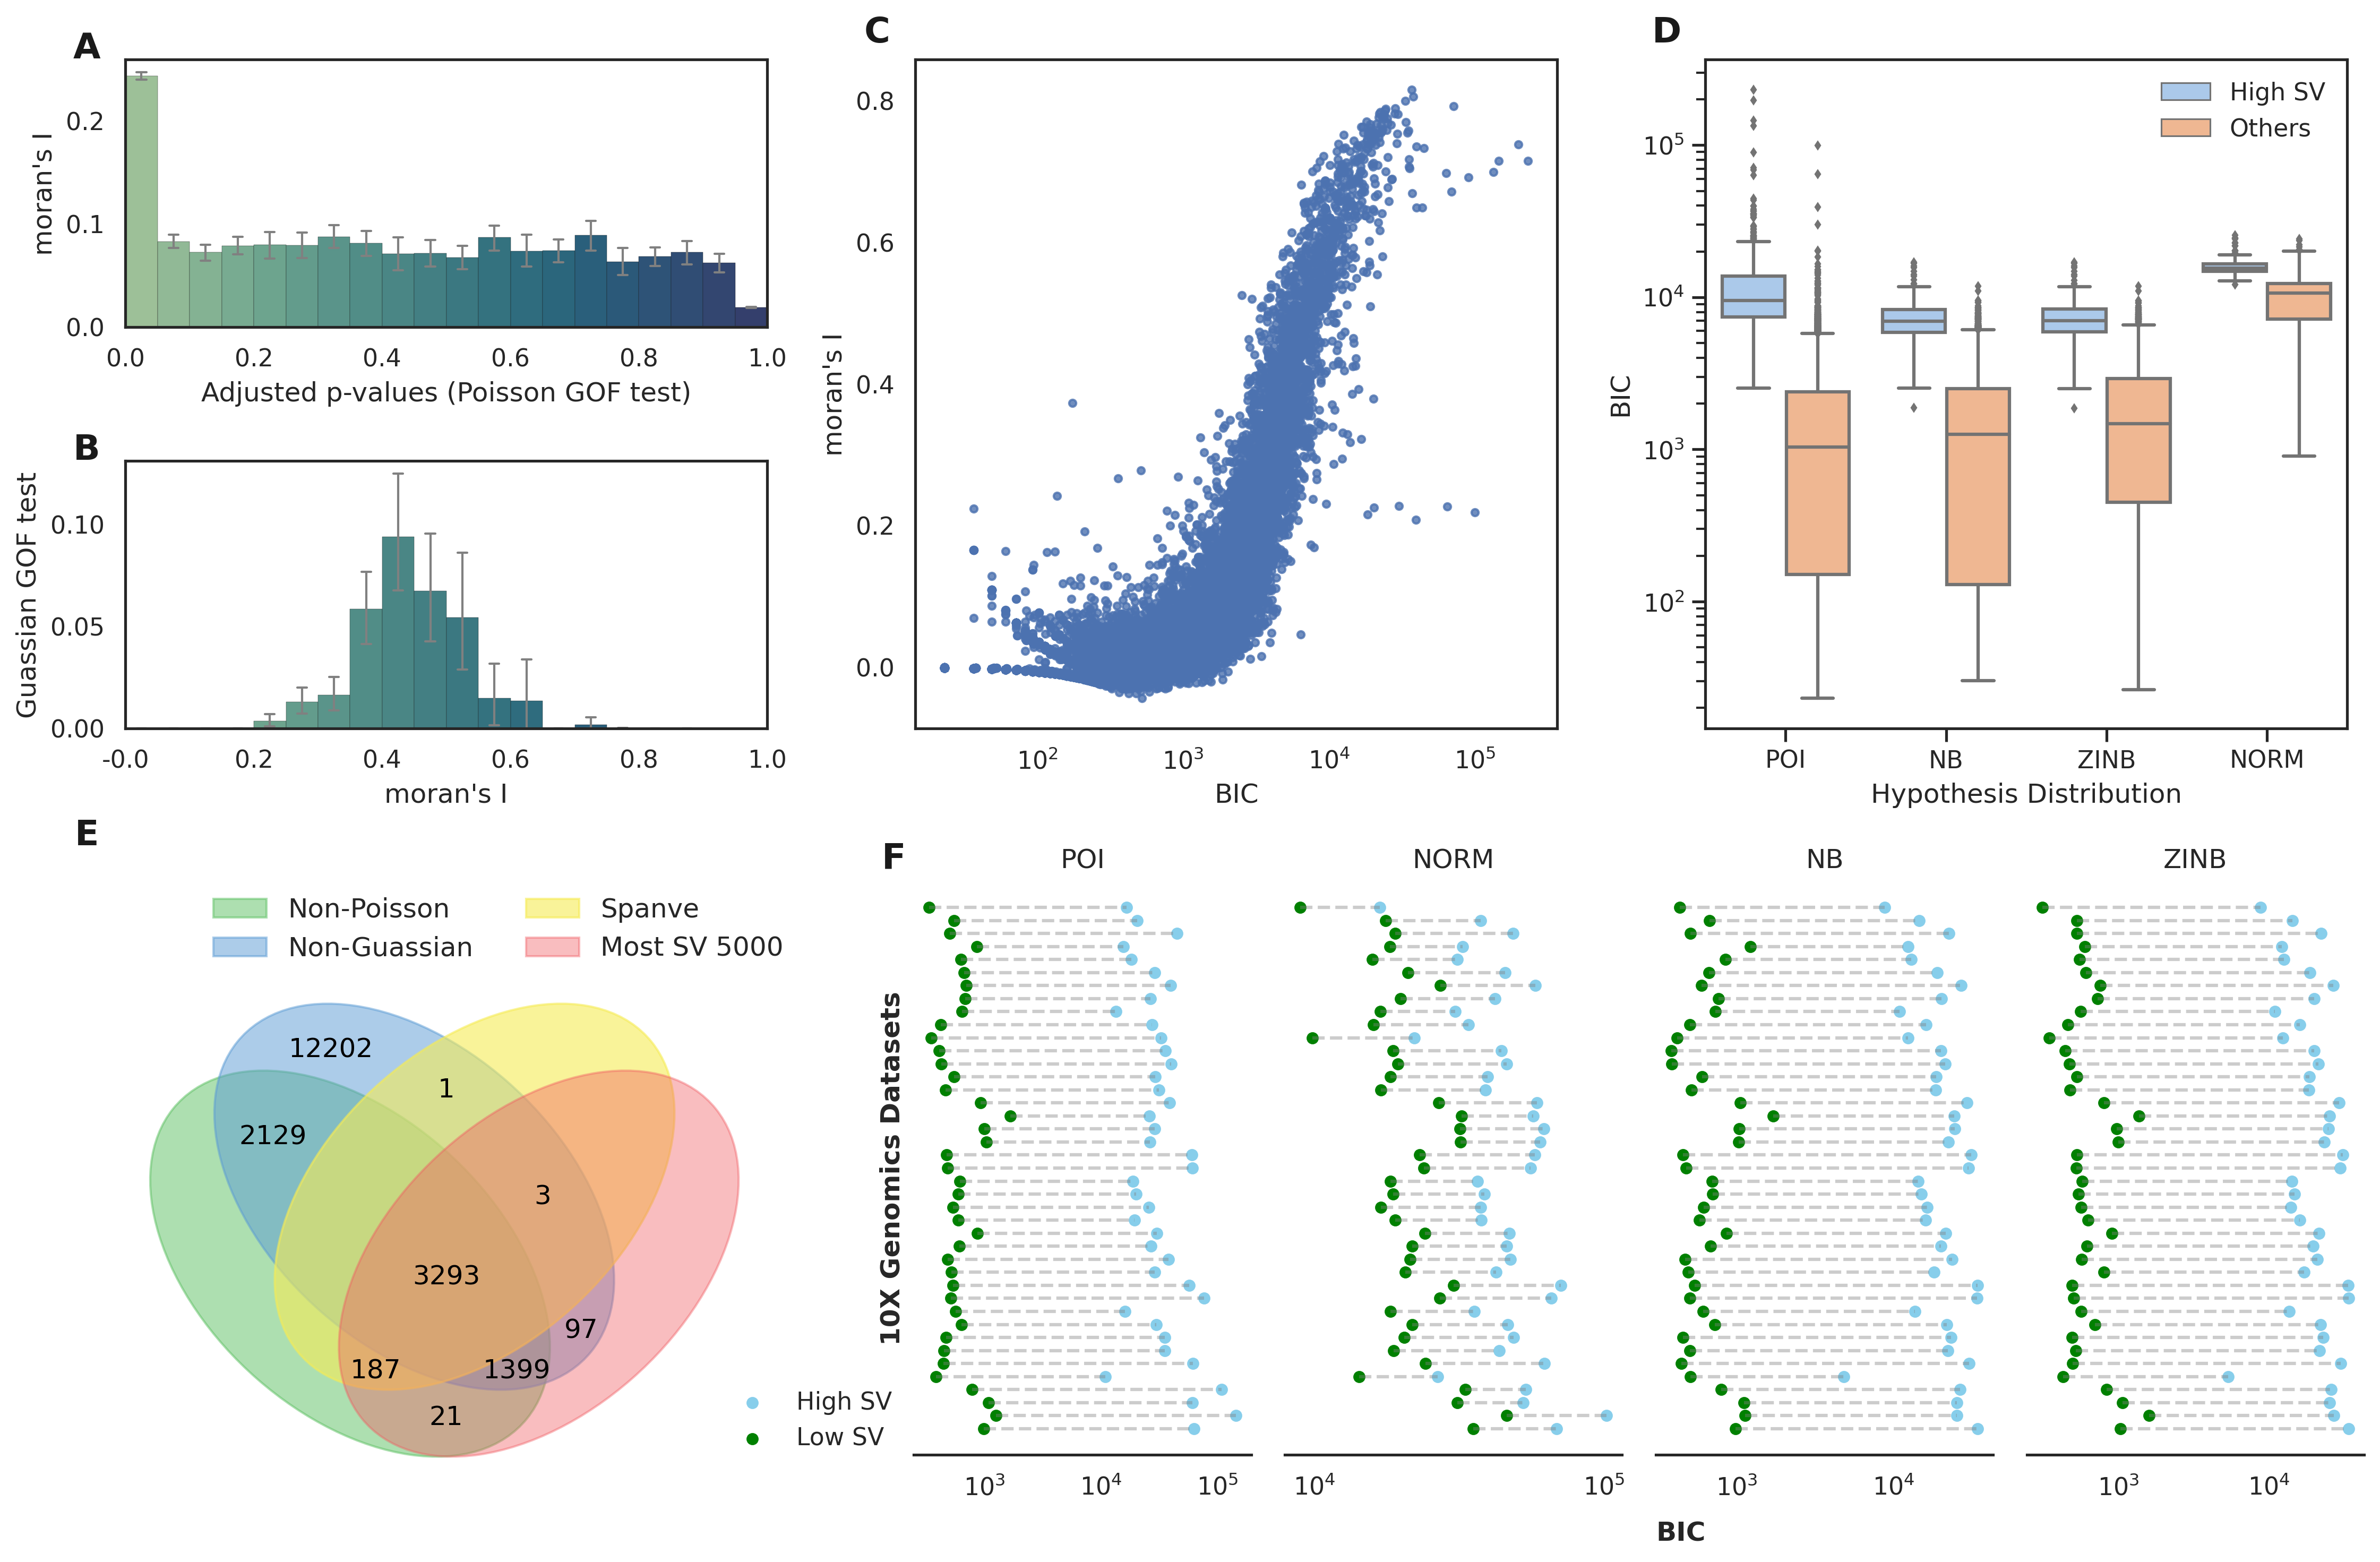

In [18]:
f

In [19]:
f.savefig('./Results/mainFigure_2_dist.pdf',bbox_inches ='tight')

# Supp. Fig

In [10]:
import warnings
warnings.filterwarnings('ignore')

used_data_dirs = './data/10XGenomics/'
use_metric = 'I'

files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
result = {}

for file in tqdm(files):
    adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
    Irecord_dir = os.path.join('./recode/10XGenomics/',file,'moran/moranI.test.csv')
    Is = pd.read_csv(Irecord_dir,index_col=0)[['pval_norm']].dropna()
    Is.columns = ['p']
    fdr_cal(Is)
    high_spatial_variable = set(Is.index[Is['fdr']<0.05])
    
    sp_res = pd.read_csv(os.path.join('./recode/10XGenomics/',file,'spanve-k/spanve.model.csv'),index_col=0)
    sp_sets = set(sp_res.index[sp_res['fdrs'] <0.05])
    
    ps = pd.Series(np.apply_along_axis(arr = adata.X,func1d=poisson_dispersion_test,axis=0),index=adata.var_names,name='p')
    poi_sets = set(ps.index[ps < 0.05])
    
    adata = adata_preprocess(adata)
    ps = pd.Series(stats.normaltest(adata.X,axis=0).pvalue,index=adata.var_names,name='p')
    norm_sets = set(ps.index[ps < 0.05])
    
    file_id = ''.join([i[0] for i in file.split('_')])
    result[file_id] = (
        len(high_spatial_variable),
        len(high_spatial_variable & poi_sets & norm_sets),
        len(high_spatial_variable & poi_sets & norm_sets & sp_sets),
        len(sp_sets - (poi_sets | norm_sets)),
        adata.shape[1]
    )

100%|██████████| 43/43 [10:10<00:00, 14.21s/it]


In [11]:
result

{'C1FHOC': (13771, 13329, 10598, 0, 18085),
 'C1FME': (18851, 18360, 12659, 0, 19465),
 'CFHLSCC': (13228, 13053, 9592, 0, 18085),
 'CFHSM': (13650, 13245, 10602, 0, 18085),
 'CFMBR': (10352, 10177, 2401, 0, 19465),
 'PVHB': (17163, 11723, 7160, 0, 36601),
 'PVHC': (15786, 9570, 2895, 0, 36601),
 'PVHG': (15877, 11387, 4139, 0, 36601),
 'PVHO': (12170, 7534, 1752, 0, 36601),
 'PVHS': (12328, 5913, 657, 0, 36601),
 'TVHBI': (663, 661, 351, 0, 1056),
 'TVHCN': (740, 737, 156, 0, 1186),
 'TVHCG': (990, 989, 363, 0, 1142),
 'TVHGPC': (907, 895, 349, 0, 1253),
 'TVHOI': (558, 551, 114, 0, 1056),
 'TVHOPC': (711, 708, 181, 0, 1253),
 'TVHSN': (685, 679, 116, 0, 1186),
 'VAMB': (11517, 11269, 1966, 0, 32285),
 'VAMBCS1': (8563, 8306, 1666, 0, 32285),
 'VAMBCS2': (8091, 7857, 1541, 0, 32285),
 'VBCBAS1': (16623, 12316, 7594, 0, 36601),
 'VBCBAS2': (16632, 12584, 7325, 0, 36601),
 'VHBS1': (12322, 5622, 1288, 0, 36601),
 'VHBS2': (14338, 5797, 1429, 0, 36601),
 'VHH': (6814, 988, 47, 0, 36601),

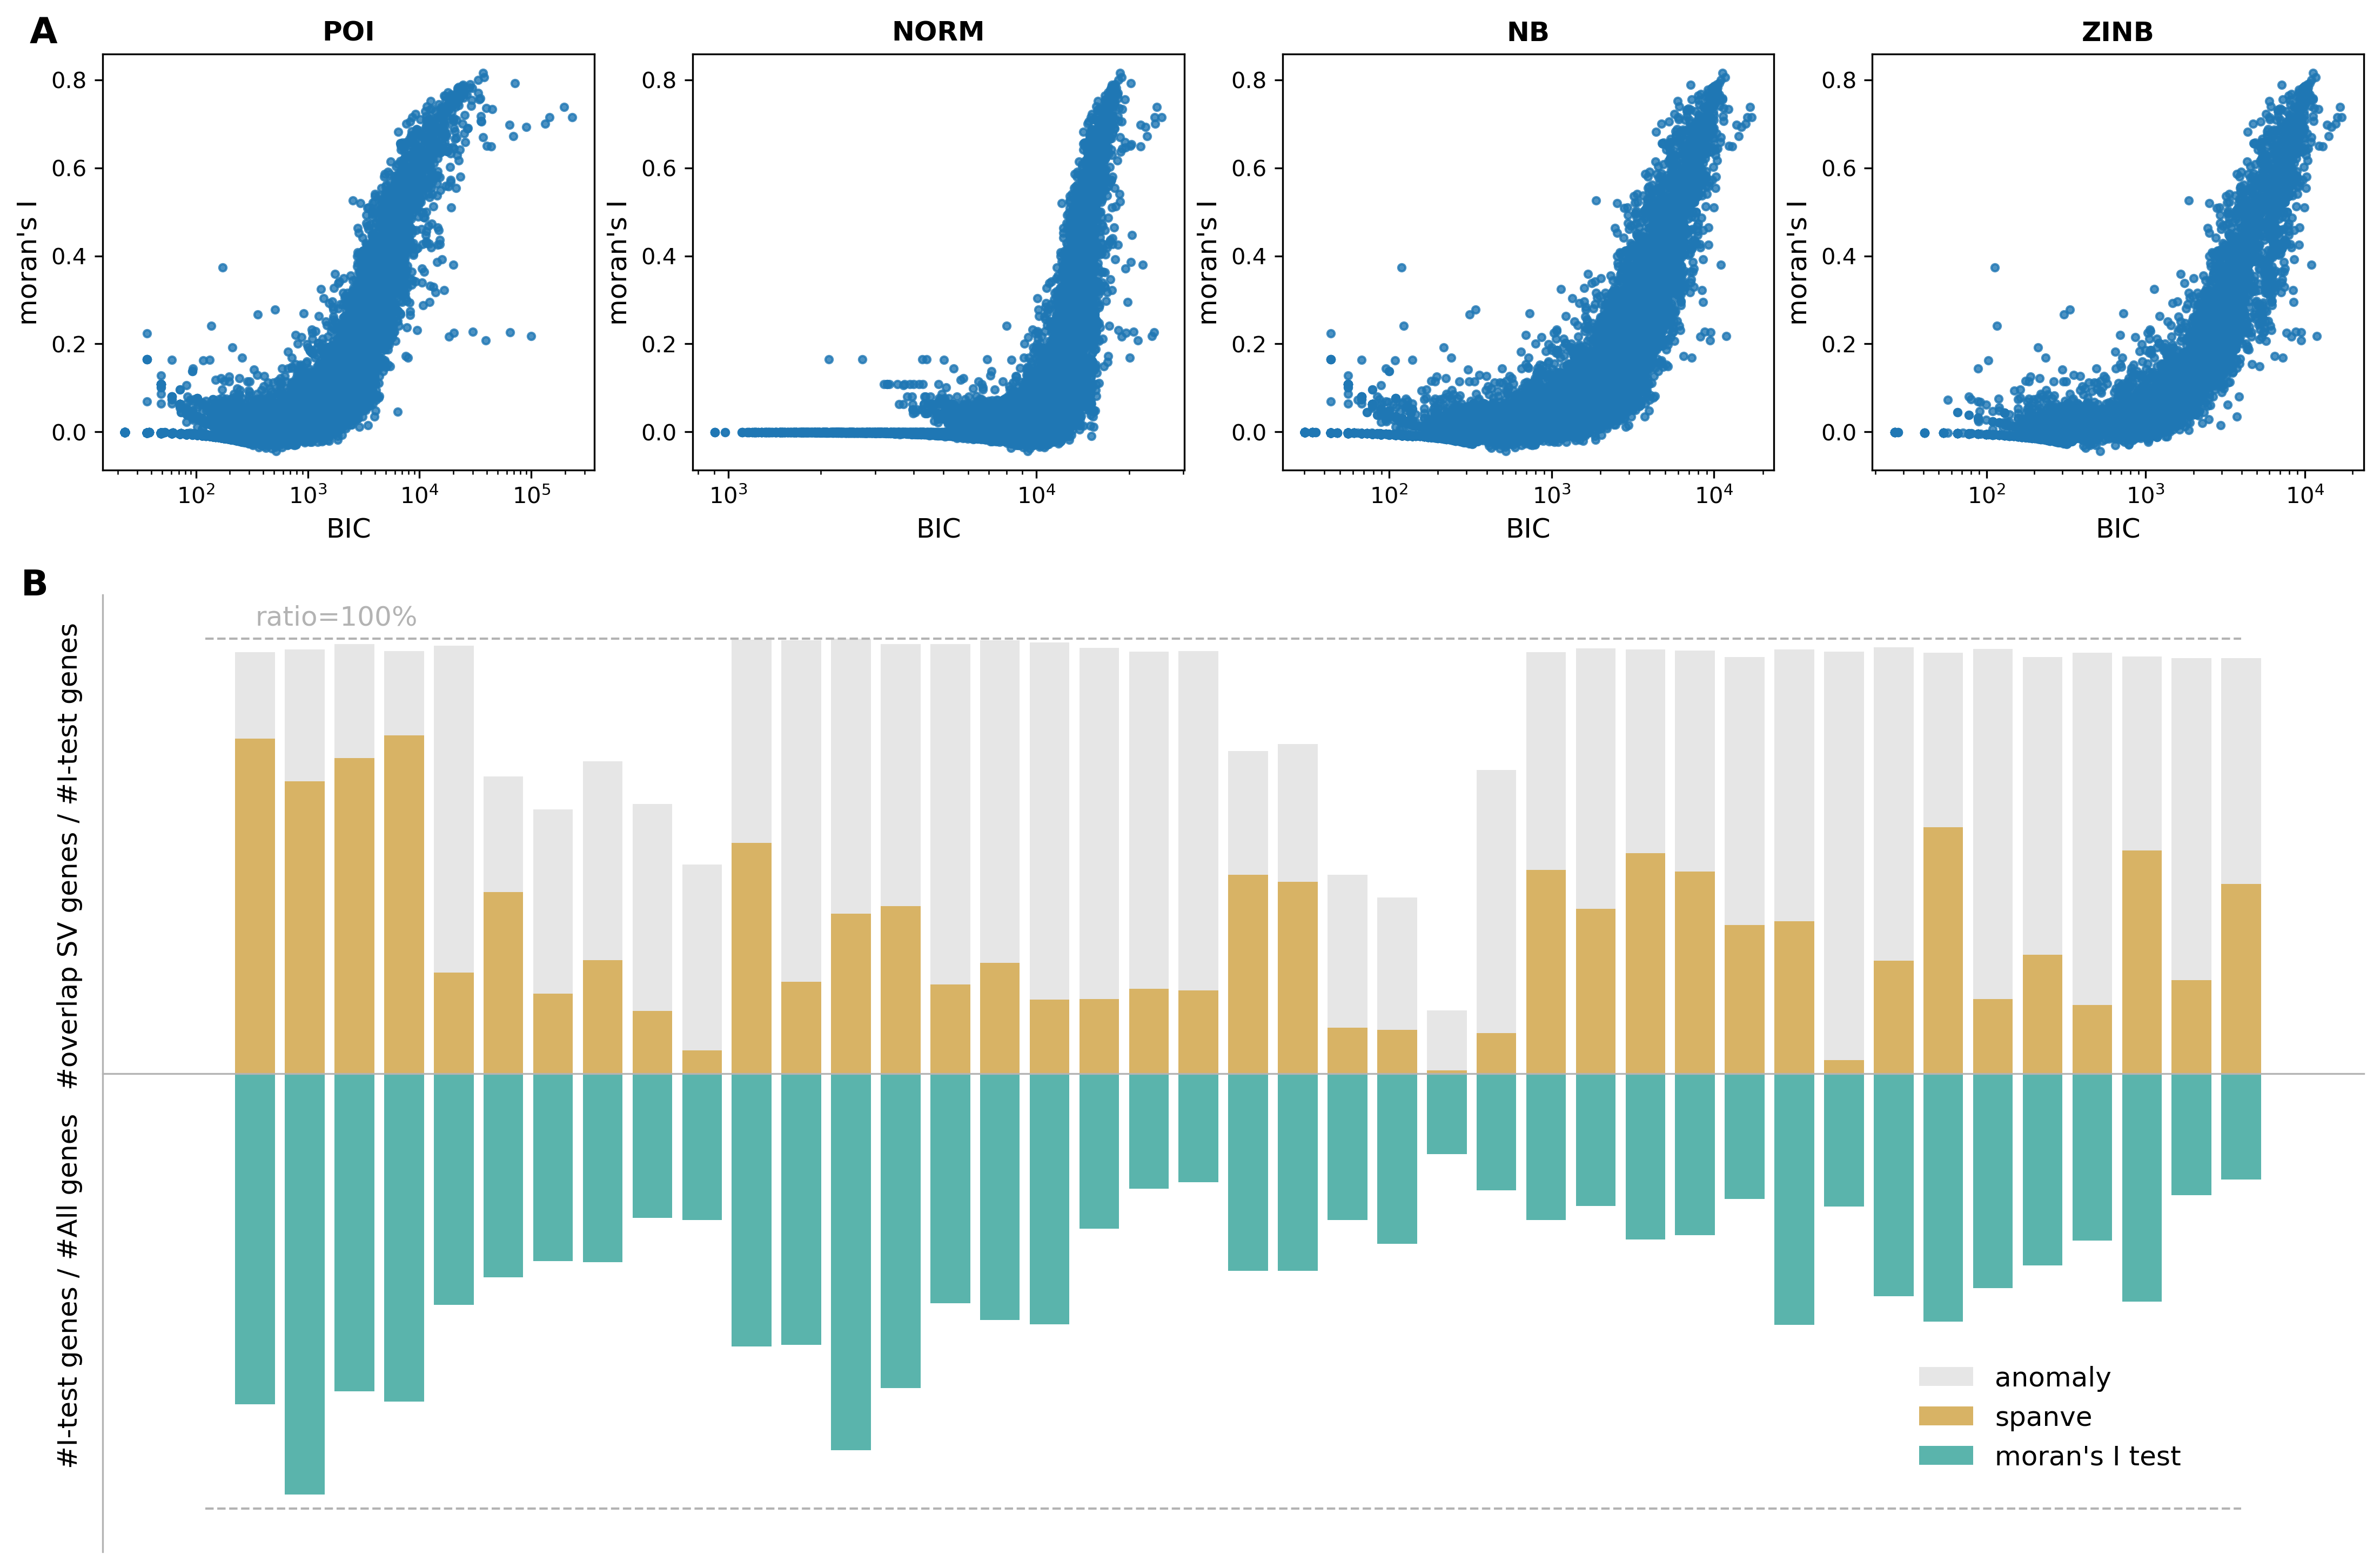

In [14]:
# example: for most and least Spatially variance
# file = files[0]
# adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
# score = get_spatial_metrics(file)[use_metric].dropna()
# genes = score.sort_values().index[-4:].to_list()
# for i,gene in enumerate(genes):
#     vis_single(adata[:,gene].X.toarray().flatten(),ax = axes[i+4],width = 1)
#     axes[i+4].set_title(f"{gene}(I={score[gene]:.2f})")
# # f.savefig('./Results/Supp.Example.Poisson_SV.pdf',bbox_inches='tight')

scale_ratio = 3
f = plt.figure(dpi=300,figsize=(6*scale_ratio,4*scale_ratio))
aspec = f.add_gridspec(
    nrows=3, ncols=4, 
    hspace=0.3
)

axes = [
    f.add_subplot(aspec[0,0]),f.add_subplot(aspec[0,1]),f.add_subplot(aspec[0,2]),f.add_subplot(aspec[0,3]),
]

for ax,bic_info,dist_type in zip(axes[:4],[bic_poi,bic_norm,bic_nb,bic_zinb],['POI','NORM','NB','ZINB']):
    ax.scatter(
        x = bic_info,
        y = spmetric.loc[df.columns,'I'].values,
        s = 10, alpha=0.8
    )
    ax.set_xscale('log')
    ax.set_xlabel('BIC',fontsize=12)
    ax.set_ylabel('moran\'s I',fontsize=12)
    ax.set_title(dist_type,fontdict={'fontweight':'bold','fontsize':12})
    
add_sublabel(ax=axes[0],label_id='A',label_loc=[-0.12, 1.05])

ax = f.add_subplot(aspec[1:,:])
x = list(range(len(result)))
ax.bar(x = x,height = [i[1] / i[0] for i in result.values()],color='#e6e6e6',label = 'anomaly')
ax.bar(x = x,height = [i[2] / i[0] for i in result.values()],color='#d8b365',label = 'spanve')
ax.bar(x = x,height = [- i[0]/i[-1] for i in result.values()],color='#5ab4ac',label = 'moran\'s I test')
sns.despine(ax=ax,top=True,right=True,bottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.hlines(y=1,xmin=-1,xmax=40,color = '.7',linestyle='--',linewidth=1)
ax.hlines(y=-1,xmin=-1,xmax=40,color = '.7',linestyle='--',linewidth=1)
ax.legend(frameon=False,fontsize=12,bbox_to_anchor = [0.93,0.22])
ax.spines['bottom'].set_position('zero')
ax.spines ['bottom'].set_color ('.7')
ax.spines ['left'].set_color ('.7')

ax.text(x=-4,y=-0.5,s='#I-test genes / #All genes',rotation='vertical',fontsize=12,verticalalignment ='center')
ax.text(x=-4,y=0.5,s='#overlap SV genes / #I-test genes',rotation='vertical',fontsize=12,verticalalignment ='center')
ax.text(x=0,y=1.03,s='ratio=100%',fontsize=12,color = '.7')

add_sublabel(ax=ax,label_id='B',label_loc=[-0.03, 1.01])

f.savefig('./Results/supp.BIC.4Dist.pdf',bbox_inches='tight')

# Achieved

In [100]:
# ## Achieved
# used_data_dirs = './data/10XGenomics/'
# use_metric = 'I'
# test_ratio = 1
# result = []
# files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
# for file in tqdm(files):
#     score = get_spatial_metrics(file)[use_metric]
#     thres = score.quantile(1-test_ratio)
#     high_spatial_variable = score.index[score >= thres]
#     adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
#     X = adata[:,high_spatial_variable].X.toarray()
#     ps = pd.Series(np.apply_along_axis(arr = X,func1d=poisson_dispersion_test,axis=0),index=high_spatial_variable,name='p')
#     ss = score[high_spatial_variable]
    
#     result.append(pd.concat([ps,ss],axis=1))

# result = pd.concat(result)

# from statsmodels.stats.multitest import multipletests

# rejects,fdrs,_,_ = multipletests(result.loc[:,'p'])
# result['fdr'] = fdrs
# f, ax = plt.subplots(dpi=300)
# ax.scatter(
#     fdrs,result.loc[:,'I'],
#     alpha = 0.8,facecolors='none',edgecolors='.3',s=3
# )
# color = sns.color_palette("deep")[1]
# ax.axvline(x=0.05, color=color, linestyle='--')
# ax.text(0.06, 0.75, 'fdr=0.05', color=color,alpha=0.8)
# ax.set_ylabel('moran\' I')
# ax.set_xlabel('False Positive Rate')
# f.savefig('./Results/Supp.I.Poisson.pdf',bbox_inches='tight')
# f.savefig('./Results/Supp.I.Poisson.tiff',dpi=600,bbox_inches='tight')
# result.to_csv('./Results/Supp.I.Poisson.csv')
# plt.close(f)

In [95]:
# # ACHIEVED
# used_data_dirs = './data/10XGenomics/'
# use_metric = 'I'
# test_ratio = 0.01

# result = []
# files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
# for file in tqdm(files):
#     adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
#     adata = adata_preprocess(adata)
#     score = get_spatial_metrics(file)[use_metric]
#     thres = score.quantile(1-test_ratio)
#     high_spatial_variable = score.index[score >= thres]
#     X = adata[:,high_spatial_variable].X.toarray()
#     ps = pd.Series(stats.normaltest(adata[:,high_spatial_variable].X.toarray(),axis=0).pvalue,index=high_spatial_variable,name='p')
#     ss = score[high_spatial_variable]
    
#     result.append(pd.concat([ps,ss],axis=1))

# result = pd.concat(result)

# from statsmodels.stats.multitest import multipletests

# rejects,fdrs,_,_ = multipletests(result.loc[:,'p'])
# result['fdr'] = fdrs
# f, ax = plt.subplots(dpi=300)
# ax.scatter(
#     result.loc[:,'p'],result.loc[:,'I'],
#     alpha = 0.8,facecolors='none',edgecolors='.3',s=3
# )
# color = sns.color_palette("deep")[1]
# ax.axvline(x=0.05, color=color, linestyle='--')
# ax.text(0.06, 0.75, 'fdr=0.05', color=color,alpha=0.8)
# ax.set_ylabel('moran\' I')
# ax.set_xlabel('False Positive Rate')
# f.savefig('./Results/Supp.I.Norm.TOP1.pdf',bbox_inches='tight')
# f.savefig('./Results/Supp.I.Norm.TOP1.tiff',dpi=600,bbox_inches='tight')
# result.to_csv('./Results/Supp.I.Norm.TOP1.csv')
# # plt.close(f)

In [ ]:
# sns.jointplot(
#     x=adata[:,'Rpl13'].to_df().values.flatten(),
#     y=adata[:,'Rplp1'].to_df().values.flatten(),
#     kind="kde", color="#4CB391",
# )


In [231]:
# thres_level = np.linspace(0,0.1,10)
# genes_decay = pd.DataFrame(index=thres_level,columns = test_merged_fdrs.columns)
# for thres in thres_level:
#     genes_decay.loc[thres,:] = (test_merged_fdrs<thres).sum()

# genes_decay.plot(kind='line')

In [ ]:
# sns.set_theme(style="whitegrid")
# sns.despine(bottom=True, left=True)

# f, ax = plt.subplots()
# sns.stripplot(
#     data=dfvis, x="value", y="group", hue="BIC",
#     dodge=True, alpha=.25, zorder=1, legend=False
# )

# # Show the conditional means, aligning each pointplot in the
# # center of the strips by adjusting the width allotted to each
# # category (.8 by default) by the number of hue levels
# sns.pointplot(
#     data=dfvis, x="value", y="group", hue="BIC",
#     join=False, dodge=.8 - .8 / 3, palette="dark",
#     markers="d", scale=.75, errorbar=None
# )

# # Improve the legend
# sns.move_legend(
#     ax, loc=[1,0], ncol=1, frameon=False, handletextpad=0,
#     title = ''
# )

# ax.set_xscale('log')
# ax.set_xlabel('BIC')
# ax.set_ylabel('')


In [10]:
# sns.set_style('white')
# ax.scatter(
#     x = adata.obsm['spatial'][:,0],
#     y =  adata.obsm['spatial'][:,1],
#     s=30,
#     c=adata.obs['cluster'],cmap='tab10',
#     marker = 'h'
# )
# ax.set_title("")
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_aspect('equal')
# add_sublabel(ax,'A')

# ax.scatter(
#     x = adata.obsm['X_umap'][:,0],
#     y = adata.obsm['X_umap'][:,1],
#     c=adata.obs['cluster'],cmap='tab10',
#     s = 10,alpha=0.8
# )
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('UMAP1')
# ax.set_ylabel('UMAP2')
# add_sublabel(ax,'A')